# Sentinel Gunshot Localization

Time Of Arrival (TOA) localization uses the time of arival of the sound at the detectors to estimate the gunshot's source location. TOA requires sunchronization and accurate TOA estimates.

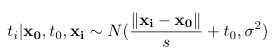

In [5]:
import numpy as np
from scipy.optimize import minimize

#### Objective Function
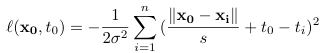

In [ ]:
def objective(theta, sensor_positions, toas, speed_of_sound):
    """
    Objective Function:
    Computes the sum of squared differences between predicted and measured TOAs.

    Parameters:
        theta : array [x0, y0, t0]
            (x0, y0) - coordinates of the unknown source
            t0 - unknown emission time
        sensor_positions : array [(xi, yi)]
            Sensor positions
        toas : array [ti]
            Time of arrivals corresponding to each sensor
        speed_of_sound : float
            Speed of sound (m/s)

    Returns: 
        residuals : float
            Sum of squared differences between predicted and measured TOAs
    """
    x0, y0, t0 = theta
    residuals = []
    for (xi, yi), ti in zip(sensor_positions, toas):
        # Calculate distance between unknow source and sensor
        distance = np.sqrt((x0 - xi)**2 + (y0 - yi)**2)
        # Predict arrival time = emmission time + travel time (distance / speed_of_sound)
        predicted_toa = t0 + distance / speed_of_sound
        residuals.append(predicted_toa - ti)
    return np.sum(np.square(residuals))

In [10]:
def localize_gunshot(sensor_positions, toas, speed_of_sound=343.0):
    """
    Localization:
    Estimate the source location and emission time given sensor positions and TOAs.

    Parameters:
        sensor_positions : array [(xi, yi)]
            Sensor positions
        toas : array [ti]
            Time of arrivals corresponding to each sensor
        speed_of_sound : float
            Speed of sound (m/s)

    Returns:
        theta : tuple
            (x0, y0) - estimated source coordinates
            t0 - estimated emission time
            Full result object from the optimizer
    """
    sensor_positions = np.array(sensor_positions)
    toas = np.array(toas)

    # Initialize source location as the mean of the sensor positions
    initial_position = np.mean(sensor_positions, axis=0)

    min_index = np.argmin(toas)
    min_toa = toas[min_index]
    sensor_min = sensor_positions[min_index]

    initial_distance = np.linalg.norm(initial_position - sensor_min)
    initial_t0 = min_toa - initial_distance / speed_of_sound

    # Initial guess for [x0, y0, t0]
    initial_guess = [initial_position[0], initial_position[1], initial_t0]
    
    # Optimize the objective function using BFGS.
    result = minimize(
        objective, 
        x0=initial_guess, 
        args=(sensor_positions, toas, speed_of_sound),
        method='BFGS'
    )
    
    if result.success:
        estimated_x, estimated_y, estimated_t0 = result.x
        return (estimated_x, estimated_y), estimated_t0, result
    else:
        raise RuntimeError("Optimization failed: " + result.message)


In [11]:
# Example sensor positions (in meters)
sensor_positions = [
    [0.0, 0.0],
    [100.0, 0.0],
    [0.0, 100.0],
    [100.0, 100.0]
]

# True source location and emission time for simulation purposes
true_source = np.array([50.0, 50.0])
true_t0 = 0.0  # Emission time in seconds
speed_of_sound = 343.0  # in m/s

# Compute ideal TOAs at each sensor (without noise)
toas = []
for sensor in sensor_positions:
    distance = np.linalg.norm(true_source - np.array(sensor))
    toa = true_t0 + distance / speed_of_sound
    toas.append(toa)

# Optionally, add Gaussian noise to simulate measurement error.
noise_std = 0.01  # standard deviation of noise in seconds
toas_noisy = toas + np.random.normal(0, noise_std, len(toas))

# Run the localization algorithm
estimated_source, estimated_t0, result = localize_gunshot(sensor_positions, toas_noisy, speed_of_sound)

print("Estimated source location (x, y):", estimated_source)
print("Estimated emission time (t0):", estimated_t0)
print("\nOptimization details:")
print(result)

/tmp/ipykernel_8940/3025372916.py:25: RuntimeWarning: overflow encountered in scalar power
  distance = np.sqrt((x0 - xi)** + (y0 - yi)**2)
/home/humphrey/work/trig/trig-env/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
/tmp/ipykernel_8940/3025372916.py:25: RuntimeWarning: invalid value encountered in scalar power
  distance = np.sqrt((x0 - xi)** + (y0 - yi)**2)


RuntimeError: Optimization failed: NaN result encountered.